## Analyzing borrowers’ risk of defaulting <a name="introduction"></a>

The goal of this project is to prepare a report for a bank’s loan division. We’ll need to find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.

This report will be considered when building a **credit scoring** of a potential customer. A ** credit scoring ** is used to evaluate the ability of a potential borrower to repay their loan.

### Step 1: Open data file & look at general info <a name="step_1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from collections import Counter

# try-except block handles errors that occur from changing file directories
try:
    data = pd.read_csv('credit_scoring_eng.csv')
except:
    data = pd.read_csv('/datasets/credit_scoring_eng.csv')


# print first 10 rows of data    
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


In [2]:
# print general information & statistics about the data

data.info()
print('')
print('')
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


           children  days_employed     dob_years  education_id  \
count  21525.000000   19351.000000  21525.000000  21525.000000   
mean       0.538908   63046.497661   

#### Conclusion <a name="step_1_conclusion"></a>

There are missing values in the 'total_income' column and 'days_employed' column that we need address. The 'days_employed' column also has negative values in it. This could be because the survey asked for start date of employment and subtracted the date the survey was taken, resulting in negative days. There are also oultiers in these columns that should be accounted for further into the analysis. The data type in these columns should be changed to int64 type since decimal precision isn't necessary for this data.

Some other things to note include max children at 20 and minumum age at 0 which may simply be typos. We also need to address duplicates that can occur due to the use of uppercase and lowercase characters to represent the same string in some columns.

### Step 2: Data preprocessing <a name="step_2"></a>

#### Processing missing values <a name="step_2_1"></a>

In [3]:
# identify & fill missing values
      
print(data.isnull().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


We can see from the above line of code that all rows that are missing values in the 'total_income' column are also missing values in the 'days_employed' column, and that the sum of these rows is the difference between total number of rows in the set and non-null values as indicated in the data info table.

Some possible reasons why these values were left out:

- these people are unemployed and have income that does not come from employment
- if the data came from a survey, maybe these people chose to leave this question blank

In [4]:
# checking sources of income for customers with missing values

print(data[(data['total_income'].isnull() == True) & (data['days_employed'].isnull() == True)]['income_type'].value_counts())

employee         1105
business          508
retiree           413
civil servant     147
entrepreneur        1
Name: income_type, dtype: int64


A deeper look at the income types for these indivuals indicates that the first case is not true, as most of these people are employees or business owners. The likely scenario is that these people didn't feel comfortable disclosing this information and chose to leave the field blank. We can check to see if there is any significant deviation in median income between males and females, and if so, fill these empty values based on the individual's gender. We use median here because, as we saw in the beginning, there are outliers that will skew the mean value.

In [5]:
# finding median income for males and females

income_male_median = data[(data['total_income'].isnull() == False) & (data['gender'] == 'M')]['total_income'].median()
print('Median male income: {:.0f}'.format(income_male_median))

income_female_median = data[(data['total_income'].isnull() == False) & (data['gender'] == 'F')]['total_income'].median()
print('Median female income: {:.0f}'.format(income_female_median))

Median male income: 26834
Median female income: 21465


Males do indeed make more than females. We'll uses these median values to fill the missing values in the 'total_income' column with the .loc method.

In [6]:
# using .loc to replace missing 'total_income' values & checking results

data.loc[(data['gender'] == 'M') & (data['total_income'].isnull() == True), 'total_income'] = income_male_median
data.loc[(data['gender'] == 'F') & (data['total_income'].isnull() == True), 'total_income'] = income_female_median
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


#### Replacing negative values <a name="step_2_2"></a>
As mentioned previously, we have negative values in the 'days_employed' column that need to be turned to positive values. We can use an if-else statement that finds negative values in the column, and then makes them postive. First, we'll write a function that achieves this, and then use the .apply() method to make the change.

In [7]:
# write function, apply it to 'days_employed' column, & check results

def make_positive(row):
    if row['days_employed'] < 0:
        return row['days_employed'] * -1
    else:
        return row['days_employed']
    
data['days_employed'] = data.apply(make_positive, axis=1)
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


We can see the negative values have been changed to positive values, while the positive values have remained the same. Now, we can address the missing values in this column. Days worked for retirees is most likely to be similar, so we can take the median of that group and fill it in for retirees who are missing that data. For everyone else, we can group by age and take the median by age group. Then we can apply this median to missing values based on age.

#### Processing missing values <a name="step_2_3"></a>

In [8]:
# finding median days employed for retirees

days_employed_retiree_median = data[(data['days_employed'].isnull() == False) & (data['income_type'] == 'retiree')]\
['days_employed'].median()

print('Median days employed for retirees: {:.0f} days'.format(days_employed_retiree_median))

Median days employed for retirees: 365213 days


This data doesn't make much sense, since 365,213 days eqauates to 1,000 years of work before retirement. It's not that bad just yet... the most likely reason is that these values are in hours instead of days. We should divide this median by 24 and then replace the missing values for retirees.

In [9]:
# using .loc to replace missing 'days_employed' values for retirees & checking results

days_employed_retiree_median = days_employed_retiree_median / 24

data.loc[(data['income_type'] == 'retiree') & (data['days_employed'].isnull() == True), 'days_employed']\
= days_employed_retiree_median

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19764 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


We can see the 413 missing values for retirees has been filled with the median days employed for that group. There are still retirees whose days employed data is in hours though, so let's convert those to days using another function and the .apply method.

In [10]:
# count occurrences where days employed is over 25000 (68 years)

print(data[data['days_employed'] > 25000]['income_type'].value_counts())

retiree       3443
unemployed       2
Name: income_type, dtype: int64


In [11]:
# write function, apply it to 'days_employed' column, & check results

def hours_to_days(row):
    if row['days_employed'] > 25000:
        return row['days_employed'] / 24
    else:
        return row['days_employed']
    
data['days_employed'] = data.apply(hours_to_days, axis=1)
print(data.describe()['days_employed'])

count    19764.000000
mean      4862.634624
std       5511.378051
min         24.141633
25%        943.506167
50%       2269.733207
75%       6232.644084
max      18388.949901
Name: days_employed, dtype: float64


The max days employed is now 18388, which equates to 50 years. Much more reasonable. Next, we'll find median days employed by age group and fill these missing values accordingly. Let's take a look at a histogram of the age column for a better idea of what age groups we should define.

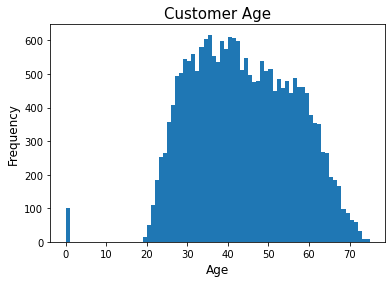

In [12]:
# plot & label histogram

plt.hist(data['dob_years'], bins=75)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Customer Age', fontsize=15)
plt.show()

Ten year increments from age 20 to age 70 should do. Anything below 20 or above 70 can get the median value of the closest grouping.

In [13]:
# calculating median number of days employed for each age group

days_employed_2030_median = data[(data['dob_years'] >= 20) & (data['dob_years'] < 30)]['days_employed'].median()
days_employed_3040_median = data[(data['dob_years'] >= 30) & (data['dob_years'] < 40)]['days_employed'].median()
days_employed_4050_median = data[(data['dob_years'] >= 40) & (data['dob_years'] < 50)]['days_employed'].median()
days_employed_5060_median = data[(data['dob_years'] >= 50) & (data['dob_years'] < 60)]['days_employed'].median()
days_employed_6070_median = data[(data['dob_years'] >= 60) & (data['dob_years'] < 70)]['days_employed'].median()

print('Median days employed, 20 to 30 age group: {:.0f}'.format(days_employed_2030_median))
print('Median days employed, 30 to 40 age group: {:.0f}'.format(days_employed_3040_median))
print('Median days employed, 40 to 50 age group: {:.0f}'.format(days_employed_4050_median))
print('Median days employed, 50 to 60 age group: {:.0f}'.format(days_employed_5060_median))
print('Median days employed, 60 to 70 age group: {:.0f}'.format(days_employed_6070_median))

Median days employed, 20 to 30 age group: 1007
Median days employed, 30 to 40 age group: 1603
Median days employed, 40 to 50 age group: 2119
Median days employed, 50 to 60 age group: 5424
Median days employed, 60 to 70 age group: 14959


Now, let's fill in the rest of these missing 'days_employed' values depending on which age range they fall in under once again with the .loc method.

In [14]:
# filling in median days employed for each age group & checking results

data.loc[(data['days_employed'].isnull() == True) & (data['dob_years'] < 30), 'days_employed'] = days_employed_2030_median

data.loc[(data['days_employed'].isnull() == True) & (data['dob_years'] >= 30) & (data['dob_years'] < 40), 'days_employed']\
= days_employed_3040_median

data.loc[(data['days_employed'].isnull() == True) & (data['dob_years'] >= 40) & (data['dob_years'] < 50), 'days_employed']\
= days_employed_4050_median

data.loc[(data['days_employed'].isnull() == True) & (data['dob_years'] >= 50) & (data['dob_years'] < 60), 'days_employed']\
= days_employed_5060_median

data.loc[(data['days_employed'].isnull() == True) & (data['dob_years'] >= 60), 'days_employed'] = days_employed_6070_median

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


#### Conclusion <a name="step_1_conclusion"></a>

Let's summarize what's been done to the raw data so far:
- filled missing 'total_income' data with medians based on gender
- turned negative values in 'days_employed' column to positive values
- filled missing 'days_worked' values for retirees with median value for retirees
- turned 'days_employed' data values over 25000 into days instead of hours
- filled missing 'days_worked' values for age groups with median value for each age group

### Step 3: Data type replacement <a name="step_3"></a>

Next, we'll replace the two float64 datatypes with int64 since, as we mentioned earlier, we don't need decimal precision for this data. We can use the .astype() method to change the data types of these two columns and check the results with .info.

In [15]:
# change data type using .astytpe method

data['days_employed'] = data['days_employed'].astype('int64')
data['total_income'] = data['total_income'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


#### Conclusion <a name="step_3_conclusion"></a>

We chose the .astype() method here because it's better suited than our other option, the to_numeric() method. The to_numeric() method changes a string to a float, while the .astype() method can change floats to integers.

### Step 4: Processing duplicates <a name="step_4"></a>

There are a few duplicates in string data where two or more strings represent the same information in different ways. This could be because of the way the data was collected. If it was through some type of online survey where participants fill in fields on their own, then we could expect to get different combinations of words that ultimately have the same meaning. Let's take a look at the columns containing qualitative data.

In [16]:
# make a list of qualitative columns & print number of unique values for each

qualitative_cols = ['education', 'family_status', 'gender', 'income_type', 'purpose']
for col in qualitative_cols:
    print('----- ' + col.upper() + ' -----')
    print(data[col].value_counts())
    print('')

----- EDUCATION -----
secondary education    13750
bachelor's degree       4718
SECONDARY EDUCATION      772
Secondary Education      711
some college             668
BACHELOR'S DEGREE        274
Bachelor's Degree        268
primary education        250
Some College              47
SOME COLLEGE              29
PRIMARY EDUCATION         17
Primary Education         15
graduate degree            4
GRADUATE DEGREE            1
Graduate Degree            1
Name: education, dtype: int64

----- FAMILY_STATUS -----
married              12380
civil partnership     4177
unmarried             2813
divorced              1195
widow / widower        960
Name: family_status, dtype: int64

----- GENDER -----
F      14236
M       7288
XNA        1
Name: gender, dtype: int64

----- INCOME_TYPE -----
employee                       11119
business                        5085
retiree                         3856
civil servant                   1459
unemployed                         2
entrepreneur         

From the answers given in each column, we can see there are duplicates in the 'education' column, where the same data is represented in a different way. We need to use the .lower() method to make all of the answers lowercase.

In [17]:
# change all values in 'education' column to lowercase & print list of unique values

data['education'] = data['education'].str.lower()
print('----- EDUCATION -----')
print(data['education'].value_counts())

----- EDUCATION -----
secondary education    15233
bachelor's degree       5260
some college             744
primary education        282
graduate degree            6
Name: education, dtype: int64


In [18]:
# check for any other duplicates left over

print('Number of duplicates left: {:.0f}'.format(data.duplicated().sum()))

Number of duplicates left: 71


In [19]:
data[data.duplicated() == True].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,2118,41,secondary education,1,married,0,F,employee,0,21464,purchase of the house for my family
3290,0,15217,58,secondary education,1,civil partnership,1,F,retiree,0,21464,to have a wedding
4182,1,1603,34,bachelor's degree,0,civil partnership,1,F,employee,0,21464,wedding ceremony
4851,0,15217,60,secondary education,1,civil partnership,1,F,retiree,0,21464,wedding ceremony
5557,0,15217,58,secondary education,1,civil partnership,1,F,retiree,0,21464,to have a wedding
6312,0,1603,30,secondary education,1,married,0,M,employee,0,26834,building a real estate
7808,0,15217,57,secondary education,1,civil partnership,1,F,retiree,0,21464,having a wedding
7921,0,15217,64,bachelor's degree,0,civil partnership,1,F,retiree,0,21464,having a wedding
7938,0,15217,71,secondary education,1,civil partnership,1,F,retiree,0,21464,having a wedding
8583,0,15217,58,bachelor's degree,0,unmarried,4,F,retiree,0,21464,supplementary education


It appears as if the remaining duplicates are the result of filling missing values in the 'total_income' and 'days_employed' columns with median values for different groups. Pandas is identifying these as duplicate rows.

#### Conclusion <a name="step_4_conclusion"></a>

The duplicates in our qualitative data were created by:
- mixture of uppercase and lowercase strings
- filling in multiple missing values with medians for certain groups

To fix the first case, we simply made all values lowercase. This condensed duplicates into the same category. The second case isn't something to be concerned about, but it helps to be aware!

### Step 5: Categorizing data <a name="step_5"></a>

In order to reach some type of conclusion and answer the questions for this project, we need to categorize the data into meaningful groups. All of the final questions deal with repaying a loan on time, which is represented by a 0 or a 1 in the 'debt' column. We'll look at the effects that the number of children, marital status, income, and reason for borrowing money have on the probability of a default. Marital statuses all fall into clean and meaningful categories, but the purpose, children, and income values do not. We'll need to fix that.

#### Categorizing purposes <a name="step_5_1"></a>

Let's take a look at the 'purpose' column. All of these values fall into 1 of 4 larger categories. We'll replace the value with the name of the category the value falls under. The following are the 4 larger categories we can identify:
- purchase real estate
- purchase a car
- fund an education
- fund a wedding

We can use stemming and the NLTK package to categorize these data values and assign them new names. Let's identify all of the stems and their frequencies first.

In [20]:
# initiate empty list, add stems to list, & count occurrences

english_stemmer = SnowballStemmer('english')

stemmed_words = []
answers = data['purpose']
for answer in answers:
    for word in answer.split(" "):
        stemmed_words.append(english_stemmer.stem(word))

for key, value in Counter(stemmed_words).items():
    print(key + ':', value)

purchas: 3314
of: 2998
the: 1288
hous: 3820
car: 4315
supplementari: 909
educ: 3526
to: 3081
have: 1551
a: 5130
wed: 2348
transact: 2610
for: 1294
my: 2396
famili: 641
buy: 4004
real: 4478
estat: 4478
commerci: 1315
residenti: 607
construct: 635
own: 2240
properti: 2542
build: 1246
second-hand: 968
with: 1281
becom: 412
get: 1316
an: 443
ceremoni: 797
higher: 426
profil: 436
univers: 949
rent: 653
out: 653
renov: 612
go: 496


With this information, we have a better idea of what stems to look for in the next step. We'll parse the 'purpose' column once again and identify stems for each row. Then, depending on what stems we find, we can set the new value to one of the 4 categories from above.

In [21]:
# parse 'purpose' column values, identify stems, & replace values

answers = data['purpose']
for answer in answers:
    for word in answer.split(" "):
        stemmed_word = english_stemmer.stem(word)
        if stemmed_word == 'car':
            data.loc[data['purpose'] == answer, 'purpose'] = 'purchase a car'
        if stemmed_word in ['hous', 'properti', 'estat']:
            data.loc[data['purpose'] == answer, 'purpose'] = 'purchase real estate'
        if stemmed_word in ['educ', 'univers']:
            data.loc[data['purpose'] == answer, 'purpose'] = 'fund an education'
        if stemmed_word == 'wed':
            data.loc[data['purpose'] == answer, 'purpose'] = 'fund a wedding'
            
print(data['purpose'].value_counts())

purchase real estate    10840
purchase a car           4315
fund an education        4022
fund a wedding           2348
Name: purpose, dtype: int64


We can see now that every value in the 'purpose' column now falls into one of the 4 categories we defined above.

#### Categorizing number of children <a name="step_5_2"></a>

The 'children' column has a few issues we'll have to handle before proceeding. We can see below that 20 and -1 children could be errors, and value less than 0 or greater than 3 are insignificant since there is such a small number of occurrences. We can filter these out so we have 4 clean and neat categories: 0 children, 1 child, 2 childern, or 3 children. We'll use this new DataFrame to answer one of the questions below.

In [22]:
# see how many values are in each category for 'children' column

print(data.children.value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


In [23]:
# define new DataFrame by filtering out 'children' > 3 and 'children' < 0

children_debt = data[(data['children'] <= 3) & (0 <= data['children'])]

#### Categorizing total income <a name="step_5_3"></a>

Finally, we'll categorize the 'total_income' column. We can split the entire column into deciles (groups of tenths) in order to gain some valuable insight in the next section. The .qcut() function contained within the pandas package is great for this operation.

The arguments here are ***x : 1d ndarray or Series*** and ***q : int or list-like float*** which represents the number of quantiles we'll divide the Series into. The output is the decile range that each data point falls into. We can create a new column in our DataFrame to use later.

In [24]:
# use .qcut() to categorize 'total_income' into deciles

data['income_deciles'] = pd.qcut(data['total_income'], 10, labels=range(1, 11))
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_deciles
0,1,8437,42,bachelor's degree,0,married,0,F,employee,0,40620,purchase real estate,9
1,1,4024,36,secondary education,1,married,0,F,employee,0,17932,purchase a car,3
2,0,5623,33,secondary education,1,married,0,M,employee,0,23341,purchase real estate,6
3,3,4124,32,secondary education,1,married,0,M,employee,0,42820,fund an education,9
4,0,14177,53,secondary education,1,civil partnership,1,F,retiree,0,25378,fund a wedding,6
5,0,926,27,bachelor's degree,0,civil partnership,1,M,business,0,40922,purchase real estate,9
6,0,2879,43,bachelor's degree,0,married,0,F,business,0,38484,purchase real estate,9
7,0,152,50,secondary education,1,married,0,M,employee,0,21731,fund an education,5
8,2,6929,35,bachelor's degree,0,civil partnership,1,F,employee,0,15337,fund a wedding,2
9,0,2188,41,secondary education,1,married,0,M,employee,0,23108,purchase real estate,6


#### Conclusion

Let's summarize what we did to categorize the data thus far:
 - Condensed the 'purpose' column into 4 larger categories
 - Removed insignificant or erroneous values from the 'children' categories
 - Categorize 'total_income' into deciles

### Step 6: Answer these questions <a name="step_6"></a>

#### Is there a relation between having kids and repaying a loan on time? <a name="step_6_1"></a>

In [25]:
# sort and print percentage of defaults for each 'children' category

debt_vs_children = children_debt.pivot_table(index='children', values='debt')
print(debt_vs_children.sort_values(by='debt', ascending=False))

              debt
children          
2         0.094404
1         0.092154
3         0.081818
0         0.075129


The percentage of defaults is higher when the customer has at least one child. This means that customers with children are slightly riskier as borrowers. 

####  Is there a relation between marital status and repaying a loan on time? <a name="step_6_2"></a>

In [26]:
# sort and print percentage of defaults for each 'family_status' category

debt_vs_family = data.pivot_table(index='family_status', values='debt')
print(debt_vs_family.sort_values(by='debt', ascending=False))

                       debt
family_status              
unmarried          0.097405
civil partnership  0.092890
married            0.075202
divorced           0.071130
widow / widower    0.065625


Unmarried customers are more likely to default, followed closely by those in civil partnerships. Married and divorced customers have roughly the same chance of defaulting, while widows/widowers have the smallest chance of defaulting on a loan.

#### Is there a relation between income level and repaying a loan on time? <a name="step_6_3"></a>

In [27]:
# sort and print percentage of defaults for each 'income_deciles' category

debt_vs_income = data.pivot_table(index='income_deciles', values='debt')
print(debt_vs_income.sort_values(by='debt', ascending=False))

                    debt
income_deciles          
7               0.097119
5               0.095632
2               0.086896
6               0.086007
8               0.083604
3               0.083140
4               0.074877
1               0.073386
9               0.070632
10              0.070135


Decile 1 is the lowest income category, while decile 10 is the highest. Just by looking at this data, it appears as if there isn't much of a correlation between income and defaults. Let's plot it to get a better idea of what we have here.

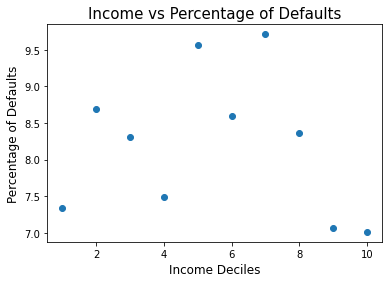

In [28]:
# define x and y coordinates, label, and plot

x = list(range(1, 11))
y = debt_vs_income * 100

plt.scatter(x, y)
plt.title('Income vs Percentage of Defaults', fontsize=15)
plt.xlabel('Income Deciles', fontsize=12)
plt.ylabel('Percentage of Defaults', fontsize=12)
plt.show()

The scatter plot gives us a better visualization and confirms that there is no correlation between income and loan defaults. This data is all over the place!

#### How do different loan purposes affect on-time repayment of the loan? <a name="step_6_4"></a>

In [29]:
# sort and print percentage of defaults for each 'purpose' category

debt_vs_purpose = data.pivot_table(index='purpose', values='debt')
print(debt_vs_purpose.sort_values(by='debt', ascending=False))

                          debt
purpose                       
purchase a car        0.093395
fund an education     0.091994
fund a wedding        0.079216
purchase real estate  0.072140


Those customers who want to purchase a car or fund an education with their loan are more likely to default than those who want to fund a wedding or buy real estate. Real estate purchases pose the smallest risk to lenders.

### Step 7: General conclusion <a name="step_7"></a>

The final goal of this project was to determine which groups of customers presented the most risk to lenders as borrowers. We were given a .csv file with information on things like income, familial status, reasons for taking out loans, and whether or not these people have defaulted on a loan in the past.

Initially, we found several problems with the data that needed to be addressed before we could proceed with the analysis. These included:
- missing values
- erroneous values
- duplicated values

We assumed missing values in the 'total_income' and 'income_type' data were due to some people being uncomfortable with disclosing this information as it may have come from a survey. In a real-life professional situation, it would be critical to communicate with the stakeholder who collected and sent the data for this project in order to discern the true reasoning behind missing values and duplicates.

For missing values, we took the median of several groups and filled missing values according to which group the customer fell into. For duplicates, we used the NLTK package and stemming in order to sort the reasons for taking out a loan into 4 larger categories. These operations made the data easier to work with during analysis.

We can then take percentages of defaults for each category and compare them to the overall percentage of defaults for the entire dataset to gain some insight for more informed business decisions.

In [30]:
# calculate percentage of defaults for different categories

debt_percentage = data['debt'].mean()
print('       All customers: {:.1f}%'.format(debt_percentage * 100))
print('--------------------------')
print('           Unmarried: {:.1f}%'.format(debt_vs_family.debt['unmarried'] * 100))
print('  Civil partnerships: {:.1f}%'.format(debt_vs_family.debt['civil partnership'] * 100))
print('                 Car: {:.1f}%'.format(debt_vs_purpose.debt['purchase a car'] * 100))
print('           Education: {:.1f}%'.format(debt_vs_purpose.debt['fund an education'] * 100))
print('           One child: {:.1f}%'.format(debt_vs_children.debt[1] * 100))
print('        Two children: {:.1f}%'.format(debt_vs_children.debt[2] * 100))

       All customers: 8.1%
--------------------------
           Unmarried: 9.7%
  Civil partnerships: 9.3%
                 Car: 9.3%
           Education: 9.2%
           One child: 9.2%
        Two children: 9.4%


It is clear to us now, after cleaning and running some basic analysis on the data, that certain groups of customers are more likely to default on a loan than the average customer. The following groups have a higher probability of missing loan payments and defaulting than their counterparts:
- Customers who are unmarried or in a civil partnership 
- Customers who want to purchase a car or an education
- Customers with 1 or 2 children